![A picture of trees and a mountain in Roosevelt National Forest from the Forest Service website.](IMG_2209_copy.jpg)


### Introduction
The code below was a lab I completed as part of my Masters of Environmental Science degree at the University of California in Santa Barbara. I have cleaned up the lab a bit to showcase it here, as I believe it is a good example of some of the machine learning skills I practiced while participating in this program. This was part of [Matteo Robins's](https://maro406.github.io/eds-232-machine-learning/) EDS 232 course: Machine Learning for Environmental Data Science. 

In this lab, I explored the application of Support Vector Machines (SVMs) and Random Forests (RFs) for multi-class classification using cartographic variables. Specifically, I predicted forest cover type based on a variety of environmental features such as elevation, soil type, and land aspect.

From the official class lab: "Understanding forest cover classification is crucial for natural resource management. Land managers and conservationists rely on accurate predictions of vegetation types to make informed decisions about wildlife habitats, fire management, and sustainable forestry practices. However, direct field assessments of forest cover can be costly and time-consuming, making predictive models a valuable tool for estimating cover types in large or inaccessible regions."

### Dataset Information

The data used for this lab comes from the [UC Irvine Machine Learning Respository](https://archive.ics.uci.edu/dataset/31/covertype). This data is not from remote sensing, but rather from cartographic variables. To quote the data webpage: "The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data.  Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data.  Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

"This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado.  These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

Some background information for these four wilderness areas: Neota (area 2) probably has the highest mean elevational value of the 4 wilderness areas. Rawah (area 1) and Comanche Peak (area 3) would have a lower mean elevational value, while Cache la Poudre (area 4) would have the lowest mean elevational value. 

As for primary major tree species in these areas, Neota would have spruce/fir (type 1), while Rawah and Comanche Peak would probably have lodgepole pine (type 2) as their primary species, followed by spruce/fir and aspen (type 5). Cache la Poudre would tend to have Ponderosa pine (type 3), Douglas-fir (type 6), and cottonwood/willow (type 4).  

The Rawah and Comanche Peak areas would tend to be more typical of the overall dataset than either the Neota or Cache la Poudre, due to their assortment of tree species and range of predictive variable values (elevation, etc.)  Cache la Poudre would probably  be more unique than the others, due to its relatively low  elevation range and species composition."

Several machine learning papers have been published using this dataset. This lab excercise is simply a way to play with this important data, and does not attempt to glean any novel new information from it. I will walk you through a step by step process of the SMV and RF techniques I practiced on this data.


### Step 0: Load Libraries and Data

In [12]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/courses/EDS232/Data/covtype_sample.csv")

### Step 1: Data Preprocessing 

Before building our classification models, I need to prepare the dataset by separating the features target variable (`Cover_Type`) and  splitting the data into training and test sets. 

I know that SVMs are sensitive to feature scale.  Here, I use `describe()` to summarize the dataset.

In [5]:
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Rawah,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2955.599500,154.450000,14.114700,268.097600,45.755300,2319.360300,212.19660,223.113500,142.243800,1960.040200,...,0.091200,0.082900,0.00250,0.00250,0.000200,0.000500,0.026800,0.024500,0.013600,2.036600
std,281.786673,111.851861,7.499705,211.899673,58.034207,1548.558651,26.98846,19.871067,37.799752,1320.535941,...,0.287908,0.275745,0.04994,0.04994,0.014141,0.022356,0.161507,0.154603,0.115829,1.383782
min,1860.000000,0.000000,0.000000,0.000000,-164.000000,0.000000,68.00000,71.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2804.750000,58.000000,9.000000,95.000000,7.000000,1091.750000,198.00000,213.000000,119.000000,1006.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2995.000000,126.000000,13.000000,218.000000,29.000000,1977.000000,218.00000,226.000000,142.000000,1699.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3159.000000,258.000000,18.000000,384.000000,68.000000,3279.000000,231.00000,237.000000,168.000000,2524.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3846.000000,359.000000,65.000000,1243.000000,427.000000,7078.000000,254.00000,254.000000,246.000000,7111.000000,...,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


*Based on what I see above, I know that some of these features have different scales. For example, the soil type columns are really small, while the distance and area columns contain a wide range of large numbers. So, I'm gonna scale it!*

In [6]:
# Separate features and target variable
X = df.drop(columns=["Cover_Type"])
y = df["Cover_Type"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

### Step 2: Hyperparameter Tuning for SVM
To optimize this SVM model, I need to search for the best hyperparameters that maximize classification accuracy. Since SVM performance depends heavily on `C`, `kernel`, and `gamma`, I will use `GridSearchCV()` to systematically test different combinations. I then initialize a cross validation object with 5 folds using `StratifiedKFold`. A resource from class: check out how `StratifiedKFold` differs from `Kfold` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). 

Then, I set up a grid to test different values of: 
- `C` (regularization strength): how strictly the model fits the training data
  - Candidate parameter values: `(0.1, 1, 10, 100)`
- `kernel` (decision boundary shape): compares linear and radial basis function shapes
  - Candidate parameter values: (linear, rbf)
- `gamma` (influence of training observations): influence of individual points on decision boundary
  - Candidate parameter values: (scale, auto)

As models and datasets become more complex, consideration of computation time becomes more important.  Here, I use `time.time()` to measure the time required to fit the grid object.  

In [7]:
# Initialize a cross validataion object with 5 folds
cv = StratifiedKFold(n_splits=5)

# Set up the parameter grid, needed for the GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Support Vector Machines! SVM, though the function is spelled SVC() for some reason
svm = SVC()

# Do the grid search!
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=0)

# Measure the time it takes to fit the grid object
start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
end_time = time.time()

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Print the time required to fit the grid object
print("Time taken to fit the grid object: {:.2f} seconds".format(end_time - start_time))

Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Time taken to fit the grid object: 498.91 seconds


### Step 3: Build a fit a Random Forest for comparison

Let's compare our SVM to a Random Forest classifier.  Here, I create a grid for cross-validation with three hyperparameters to tune, along with three sensible values for each one.  

In [9]:
# OK, lets do a random forest to make comparisons
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Call in the RF model
rf = RandomForestClassifier(random_state=42)

# Do the grid search, but on the rf
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=cv, n_jobs=-1, verbose=0)

# Do the same fancy time trick
start_time_rf = time.time()
grid_search_rf.fit(X_train_scaled, y_train)
end_time_rf = time.time()

# Print the best parameters
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

# Print the time required to fit the grid object
print("Time taken to fit the Random Forest grid object: {:.2f} seconds".format(end_time_rf - start_time_rf))

Best Parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Time taken to fit the Random Forest grid object: 14.68 seconds


### Step 4: Model Predictions and Evaluation
Now that I have trained and optimized both a SVM and RF model, I evaluate their performances on the test set to prepare for model comparison. The steps I take are:
- Use the best models from `GridSearchCV()` to make predictions on the test set
- Generate a confusion matrix for each model to visualize classification performance


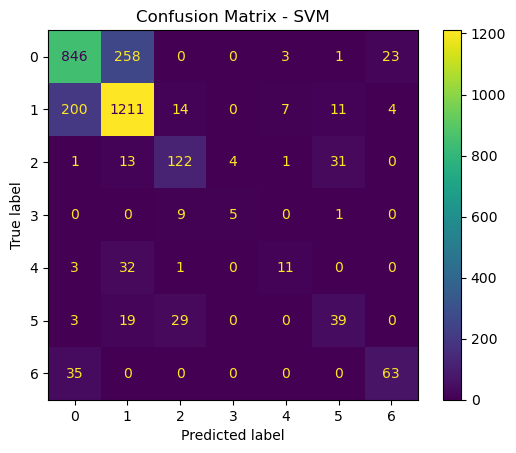

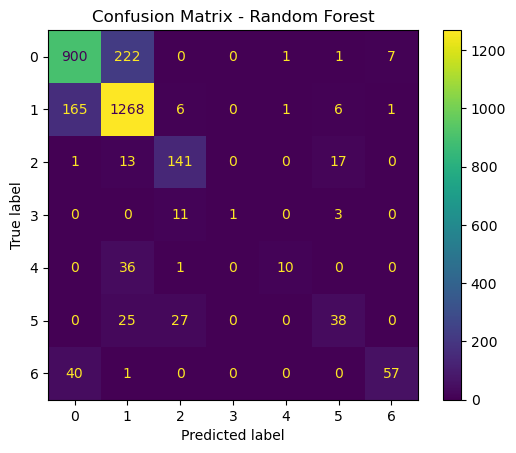

In [13]:
# Best SVM model from GridSearchCV
best_svm = grid_search.best_estimator_

# Best Random Forest model from GridSearchCV
best_rf = grid_search_rf.best_estimator_

# Make predictions on the test set
y_pred_svm = best_svm.predict(X_test_scaled)
y_pred_rf = best_rf.predict(X_test_scaled)

# Confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot()
plt.title("Confusion Matrix - SVM")
plt.show()

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()

### Step 5: Gather and display additional performance metrics
Now, I want to display the accuracy score and training time required for each model to so I can compare the models.

In [14]:
# Calculate accuracy scores
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Print accuracy scores and training times
print("Accuracy for SVM: {:.2f}".format(accuracy_svm * 100))
print("Time taken to fit the SVM grid object: {:.2f} seconds".format(end_time - start_time))

print("Accuracy for Random Forest: {:.2f}".format(accuracy_rf * 100))
print("Time taken to fit the Random Forest grid object: {:.2f} seconds".format(end_time_rf - start_time_rf))

Accuracy for SVM: 76.57
Time taken to fit the SVM grid object: 498.91 seconds
Accuracy for Random Forest: 80.50
Time taken to fit the Random Forest grid object: 14.68 seconds


### Step 6: Compare the models
Now that we have trained, optimized, and evaluated both SVM and RF models, we will compare them based on overall accuracy, training time, and types of errors made.

*The accurace for SVM is a little bit lower, at around 76.57, whereas the accuracy of RF was 80.50. The time it took to run the SVM was also significantly longer, at 498.91 seconds, as opposed to 14.68 seconds. So in general, I think that in this case, the random forest model is the better choice. In a scenario where computation time was not an issue, an argument could be made for SVM. But if simplicity is the name of the game, than Random Forests is the way to go.*